In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
os.chdir("..")

#### Importação Bibliotecas

In [3]:
from calysto.utils import load_settings
from calysto.feature_engineering import Engineering
from calysto.model_selection import Training
from calysto.submission import KaggleSubmission

#### Load Settings

In [4]:
kaggle_params = json.load(open("settings/main.json", "r"))
model_params = json.load(open("settings/train.json", "r"))
feature_params = json.load(open("settings/dataprep_best.json", "r"))

#### Read Data

In [5]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

#### Feature Engineering

In [6]:
data = Engineering(train)

In [7]:
X = data.feature(feature_params)

In [8]:
y = data.target("SalePrice")

#### Model training

In [9]:
model = Training(X, y, model_params)

In [10]:
model.train_test_split()

In [11]:
model.gridsearch(random=False)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   27.4s finished


GridSearchCV(estimator=Pipeline(steps=[('estimator',
                                        GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid=[{'estimator': [GradientBoostingRegressor(alpha=0.3,
                                                                  learning_rate=0.08,
                                                                  loss='huber',
                                                                  min_impurity_decrease=0,
                                                                  min_samples_split=4,
                                                                  n_estimators=750,
                                                                  random_state=1903,
                                                                  subsample=0.5)],
                          'estimator__alpha': [0.3],
                          'estimator__learning_rate': [0.08],
                          'estimator__max_depth': [2, 3],
     

In [12]:
best_model = model.best()

In [13]:
model.results.best_params_

{'estimator': GradientBoostingRegressor(alpha=0.3, learning_rate=0.08, loss='huber',
                           min_impurity_decrease=0, min_samples_split=4,
                           n_estimators=750, random_state=1903, subsample=0.5),
 'estimator__alpha': 0.3,
 'estimator__learning_rate': 0.08,
 'estimator__max_depth': 3,
 'estimator__min_impurity_decrease': 0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 4,
 'estimator__n_estimators': 750,
 'estimator__subsample': 0.5}

In [14]:
importance = pd.DataFrame()
importance["value"] = best_model.feature_importances_
importance["var"] = model.X_train.columns

In [15]:
importance.sort_values("value", ascending = False).head(30)

,value,var
45,0.359271,OverallQual
35,0.181005,GrLivArea
86,0.065967,FullBath
40,0.054283,TotalBsmtSF_miss_num
119,0.037588,KitchenQual_grade
53,0.028364,LotArea
129,0.026335,GarageArea_miss_num
124,0.023154,GarageCars_miss_num
30,0.022211,1stFlrSF
114,0.018142,BsmtFinSF1_miss_num


In [16]:
importance[importance["value"] == 0]

,value,var
9,0.0,Neighborhood_Blueste
24,0.0,Condition1_tipo2
50,0.0,Condition1_tipo1
91,0.0,Neighborhood_NPkVill
113,0.0,RoofStyle_Shed
120,0.0,RoofStyle_Mansard


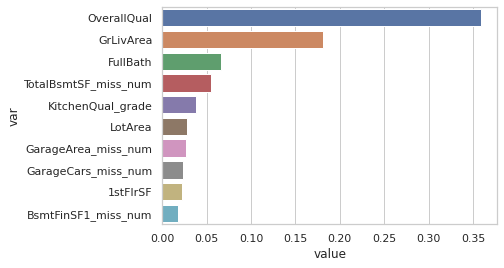

In [17]:
import seaborn as sns
sns.set(style="whitegrid")
datq = importance[importance['value']>0].sort_values("value", ascending = False).head(10)
ax = sns.barplot(y="var", x="value", data=datq)

In [18]:
model.results.best_params_

{'estimator': GradientBoostingRegressor(alpha=0.3, learning_rate=0.08, loss='huber',
                           min_impurity_decrease=0, min_samples_split=4,
                           n_estimators=750, random_state=1903, subsample=0.5),
 'estimator__alpha': 0.3,
 'estimator__learning_rate': 0.08,
 'estimator__max_depth': 3,
 'estimator__min_impurity_decrease': 0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 4,
 'estimator__n_estimators': 750,
 'estimator__subsample': 0.5}

In [42]:
model.save()

In [44]:
train_mse = model.metrics()

#### Validação

In [20]:
valid_mse = model.validate()

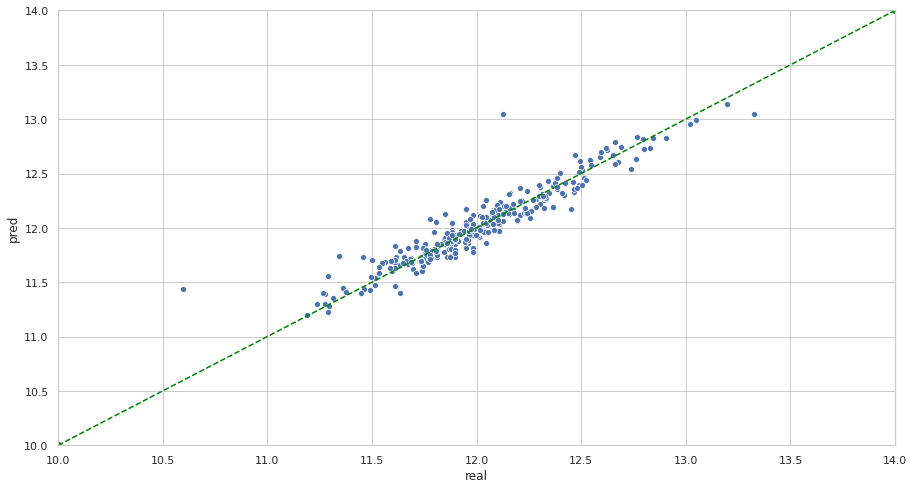

In [21]:
plt.figure(figsize=(15,8))
plt.ylim(10, 14)
plt.xlim(10, 14)
model.corrplot()
plt.plot([10,14], [10, 14], color='green', marker='o', linestyle='dashed')

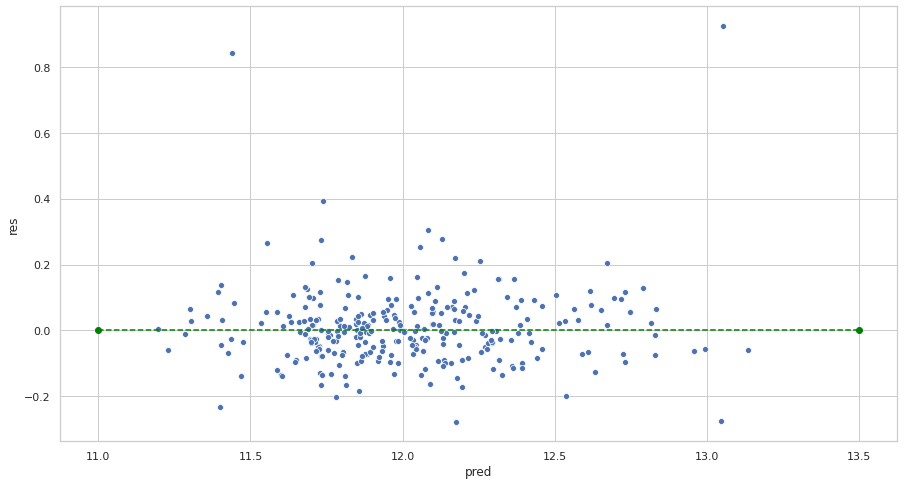

In [22]:
plt.figure(figsize=(15,8))
model.hetplot()
plt.plot([11,13.5], [0, 0], color='green', marker='o', linestyle='dashed')

#### Predição do conjunto de teste

In [23]:
test_data = Engineering(test)

In [24]:
X_test = test_data.feature(feature_params)

In [25]:
y_pred_test = best_model.predict(X_test)

In [26]:
y_pred_test_transform = test_data.detarget(y_pred_test)

### Submissão ao Kaggle

In [27]:
predictions = KaggleSubmission(kaggle_params)

In [28]:
predictions.save(test, y_pred_test_transform)

'submissions/house-prices-advanced-regression-techniques-2020-Jul-26-19-01-07.csv'

predictions.submit(message = "feature_eng melhorada")

### Versionamento do experimento

In [29]:
import neptune

In [30]:
neptune.init('adelmofilho/' + kaggle_params["competition_name"])

Project(adelmofilho/house-prices-advanced-regression-techniques)

In [36]:
neptune.create_experiment(name="new features", params={"feature": feature_params,
                                                       "model":model_params[0],
                                                      "best_parameters": model.results.best_params_})

NVMLError: NVML Shared Library Not Found - GPU usage metrics may not be reported.


https://ui.neptune.ai/adelmofilho/house-prices-advanced-regression-techniques/e/HOUSE-383


Experiment(HOUSE-383)

In [43]:
(train_mse, valid_mse)

(0.005674091892513387, 0.014361010547800297)

In [37]:
neptune.log_metric('mean_squared_error_train',train_mse)
neptune.log_metric('mean_squared_error_valid',valid_mse)

In [38]:
neptune.log_metric('mean_squared_error_test', 0.12592)